<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A minimal implementation of **SimSiam** as proposed in [Exploring Simple Siamese Representation Learning](https://arxiv.org/pdf/2011.10566.pdf) by Xinlei Chen and Kaiming He. The objective of this notebook is to demonstrate the workflow of SimSiam and NOT to implement it note to note and at the same time I will try not to miss out on the major bits discussed in the paper. For that matter, I'll be using the Flowers dataset. 

Following depicts the workflow of SimSiam - 

<center>
<img src="https://i.ibb.co/37pNQTP/image.png" width=550></img>
</center>

In [1]:
#!pip install -U -q tensorflow-addons

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [3]:
#import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os
from skimage import io
from skimage.transform import resize

from tqdm import tqdm

#tf.random.set_seed(666)
#np.random.seed(666)

#tfds.disable_progress_bar()

In [4]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
## Gather Flowers dataset
#train_ds, validation_ds = tfds.load(
#    "tf_flowers",
#    split=["train[:85%]", "train[85%:]"]
#)

In [4]:
dataset_one = tf.keras.preprocessing.image_dataset_from_directory(
    'TCGA_Data/train1/',
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 16,
    image_size = (224, 224),
)

dataset_two = tf.keras.preprocessing.image_dataset_from_directory(
    'TCGA_Data/train2/',
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 16,
    image_size = (224, 224),
)

Found 5247 files belonging to 4 classes.
Found 5247 files belonging to 4 classes.


Note the augmentation pipeline is a bit different from the augmentations followed in the paper. 

The network architectures are based on the **Method (Baseline settings)** section of the paper. 

## Encoder ($f$)

This includes ResNet50 as a backbone and another MLP for projection. Note that I have reduced the architectures here leaving ResNet50 backbone intact. 

In [6]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

## Predictor ($h$)

This includes an MLP. 

In [7]:
def get_predictor():
    inputs = tf.keras.layers.Input((2048, ))
    x = tf.keras.layers.Dense(512, activation='relu', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    p = tf.keras.layers.Dense(2048)(x)

    h = tf.keras.Model(inputs, p)

    return h

In [8]:
get_encoder().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
Total params: 31,986,560
Trainable params: 31,929,344
Non-trainable params: 57,216
_____________________________________

In [9]:
get_predictor().summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


The authors have also provided PyTorch-like psuedocode in the paper (how cool!) - 

```python
# f: backbone + projection mlp
# h: prediction mlp
for x in loader: # load a minibatch x with n samples
    x1, x2 = aug(x), aug(x) # random augmentation
    z1, z2 = f(x1), f(x2) # projections, n-by-d
    p1, p2 = h(z1), h(z2) # predictions, n-by-d
    L = D(p1, z2)/2 + D(p2, z1)/2 # loss
    L.backward() # back-propagate
    update(f, h) # SGD update

def D(p, z): # negative cosine similarity
    z = z.detach() # stop gradient
    p = normalize(p, dim=1) # l2-normalize
    z = normalize(z, dim=1) # l2-normalize
    return -(p*z).sum(dim=1).mean()
```

In [10]:
def loss_func(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return - tf.reduce_mean(tf.reduce_sum((p*z), axis=1))

In [11]:
@tf.function
def train_step(ds_one, ds_two, f, h, optimizer):
    with tf.GradientTape() as tape:
        z1, z2 = f(ds_one), f(ds_two)
        p1, p2 = h(z1), h(z2)
        loss = loss_func(p1, z2)/2 + loss_func(p2, z1)/2
    
    learnable_params = f.trainable_variables + h.trainable_variables
    gradients = tape.gradient(loss, learnable_params)
    optimizer.apply_gradients(zip(gradients, learnable_params))

    return loss

In [12]:
def train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for ds_one, ds_two in zip(dataset_one, dataset_two):
            loss = train_step(ds_one, ds_two, f, h, optimizer)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, f, h

In [13]:
decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

f = get_encoder()
h = get_predictor()

epoch_wise_loss, f, h  = train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=50)

  2%|█▌                                                                              | 1/50 [02:08<1:45:15, 128.89s/it]

epoch: 1 loss: -0.879


 22%|█████████████████▌                                                              | 11/50 [18:32<1:04:05, 98.61s/it]

epoch: 11 loss: -0.977


 42%|██████████████████████████████████▍                                               | 21/50 [34:57<47:35, 98.47s/it]

epoch: 21 loss: -0.982


 62%|██████████████████████████████████████████████████▊                               | 31/50 [51:22<31:13, 98.59s/it]

epoch: 31 loss: -0.983


 82%|█████████████████████████████████████████████████████████████████▌              | 41/50 [1:07:49<14:47, 98.61s/it]

epoch: 41 loss: -0.984


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:22:37<00:00, 99.14s/it]


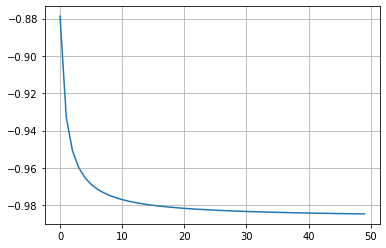

In [14]:
plt.plot(epoch_wise_loss)
plt.grid()
plt.show()

In [15]:
f.save_weights("projection_TCGA.h5")
h.save_weights("prediction_TCGA.h5")